In [0]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from scipy import stats

In [0]:
"""Function provided with assignment for data generation"""

def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [0]:
""" Model just returns paramters corresponding to the given input """

def model(theta,input_batch):
    sm = torch.nn.Softmax(dim=0)
    return torch.gather(sm(theta), 0, input_batch-1)

""" Negative Log Likelihood """

def curr_loss(output):
    return torch.mean(-1*torch.log2(output))

In [0]:
data = sample_data()
batch_size = 512

train_set, validation_set, test_set = torch.utils.data.random_split(data,
                                                                    (int(len(data) * .6),
                                                                     int(len(data) * .2),
                                                                     int(len(data) * .2)))

training_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
validation_data = torch.from_numpy(validation_set[0:len(validation_set)])
test_data = torch.from_numpy(test_set[0:len(test_set)])

In [0]:
torch.manual_seed(0)

theta = torch.autograd.Variable(torch.zeros(100,), requires_grad=True)
optimizer = torch.optim.Adam([theta], lr=0.001)
epochs = 250

training_loss = []
validation_loss = []

""" Training loop """

for i in range(epochs):
    m = 0
    for batch in training_data:
        optimizer.zero_grad()
        loss = curr_loss(model(theta, batch))
        loss.backward()
        optimizer.step()
        training_loss.append(loss)
        m += 1

    val_loss = curr_loss(model(theta, validation_data))

    for j in range(m):
      validation_loss.append(val_loss)


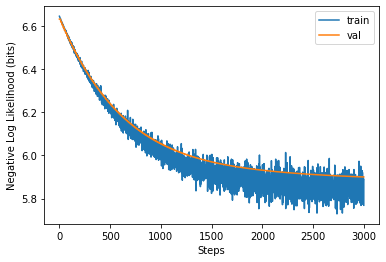

In [51]:
""" Training vs. Validation Set Performance Throughout Training """

plt.xlabel('Steps')
plt.ylabel('Negative Log Likelihood (bits)')
plt.plot(training_loss,label='train')
plt.plot(validation_loss,label='val')
plt.legend()
plt.show()

In [52]:
print("Test set performance:",curr_loss(model(theta, test_data)).item(),"bits")

Test set performance: 5.818539619445801 bits


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  after removing the cwd from sys.path.


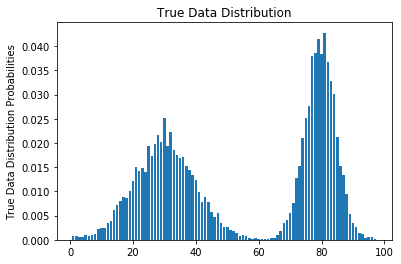

In [53]:
plt.title('True Data Distribution')
plt.ylabel('True Data Distribution Probabilities')

freq = stats.itemfreq(data)
x = freq[:, 0]
y = freq[:, 1] / len(data)
plt.bar(x,y)
plt.show()

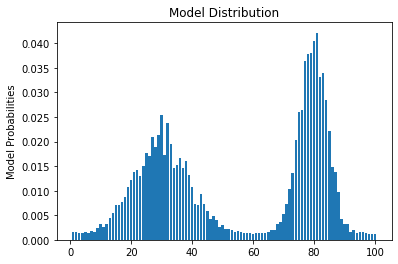

In [54]:
""" Passing in input to return all model parameters """

plt.title("Model Distribution")
plt.ylabel('Model Probabilities')

param_index = np.arange(1,101,1)
probabilities = model(theta,torch.from_numpy(param_index))

plt.bar(param_index,probabilities.detach().numpy())
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: `itemfreq` is deprecated!
`itemfreq` is deprecated and will be removed in a future version. Use instead `np.unique(..., return_counts=True)`
  


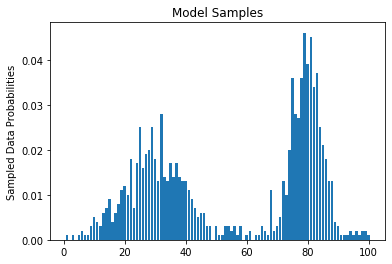

In [55]:
plt.title("Model Samples")
plt.ylabel('Sampled Data Probabilities')

prob_dist = torch.distributions.Categorical(probabilities)
samples = prob_dist.sample([1000]) + 1
empirical_freq = stats.itemfreq(samples.detach().numpy())
empirical_x = empirical_freq[:, 0]
empirical_y = empirical_freq[:, 1] / len(samples)

plt.bar(empirical_x,empirical_y)
plt.show()